In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/users/aqib/desktop/ucsb/research/bccl/dmd_codes')
from monomials import Monomials
from monomials import Monomials_xu
import seaborn as sn
import pickle

In [53]:
plt.rcParams.update({'font.size':20})

# DMD with control

In [ ]:
def calc_Input_Koopman(data_x_p,data_x_f,data_u,data_xu,trunc_cond=1e-15):
    
    n,m,l = data_x_p.shape
    p = data_u.shape[0]
    q = data_xu.shape[0]
    
    data_x_p = data_x_p.reshape((n,m*l),order='F')
    data_x_f = data_x_p.reshape((n,m*l),order='F')
    data_u = data_u.reshape((p,m*l),order='F')
    data_xu = data_xu.reshape((q,m*l),order='F')
    
    Omega = (np.vstack((data_x_p,data_xu,data_u)))
    
    K = data_x_f @ np.linalg.pinv(Omega,trunc_cond)
    
    A = K[:,0:K.shape[0]]
    B = K[:,K.shape[0]:]
    
    return ([K,A,B]);

#  ODEs

In [2]:
global Kd1, Kd2, Kd3, delta0, delta1, delta2, delta3, delta4, k0, k1, k2, k3, k4, k5

Kd1 = 0.05
Kd2 = 0.05
Kd3 = 0.05
Kd4 = 0.05
minParams = 0.1
maxParams = 0.4
delta0 = np.random.uniform(minParams,maxParams)
delta1 = np.random.uniform(minParams,maxParams)
delta2 = np.random.uniform(minParams,maxParams)
delta3 = np.random.uniform(minParams,maxParams)
delta4 = np.random.uniform(minParams,maxParams)
k0 = np.random.uniform(minParams,maxParams)
k1 = np.random.uniform(minParams,maxParams)
k2 = np.random.uniform(minParams,maxParams)
k3 = np.random.uniform(minParams,maxParams)
k4 = np.random.uniform(minParams,maxParams)
k5 = np.random.uniform(minParams,maxParams)


def iff_loop(x,t,u): 
    
    xdot = np.zeros(len(x))
    xdot[0] = k0*u[0]/(1+u[1]/Kd4) - delta0*x[0] 
    xdot[1] = k1*u[1]/(1+x[0]/Kd1) - delta1*x[1]
    xdot[2] = k2*x[1] + k3*u[0] - 1.5*delta2*x[2]
    xdot[3] = k4*u[1]/(1+x[2]/Kd2) - delta3*x[3]
    xdot[4] = k5*u[0]/(1+x[3]/Kd3) - 1.2*delta4*x[4]
        
    return (xdot)
    

# numerically integrate the ODEs

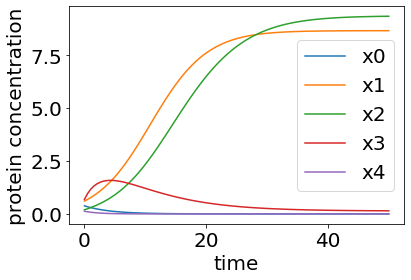

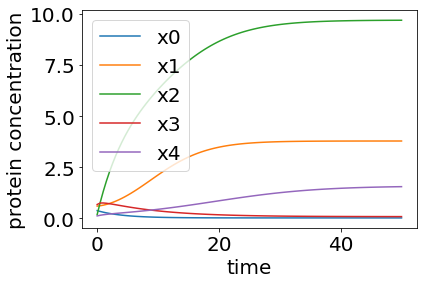

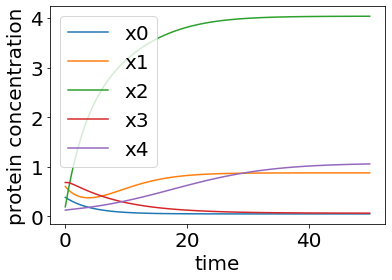

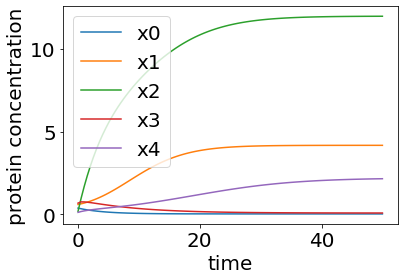

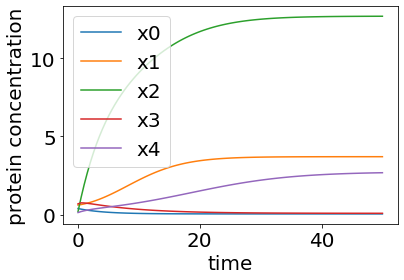

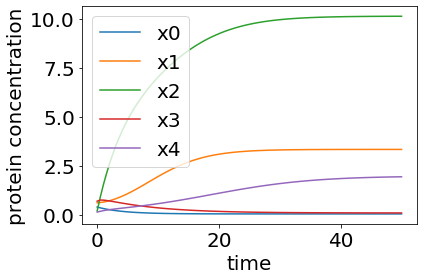

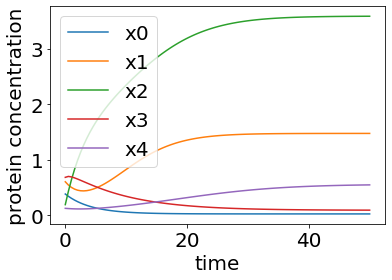

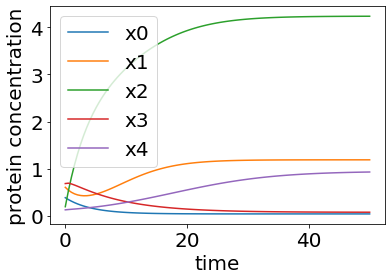

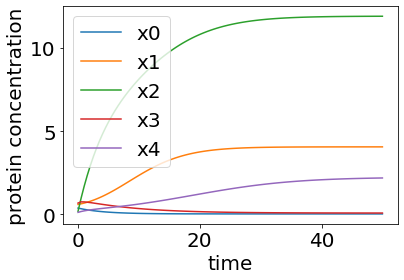

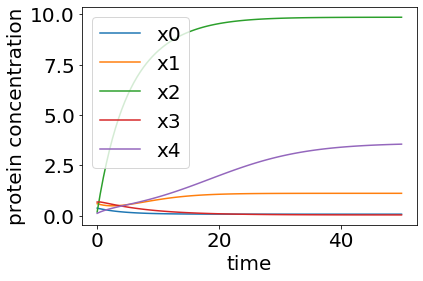

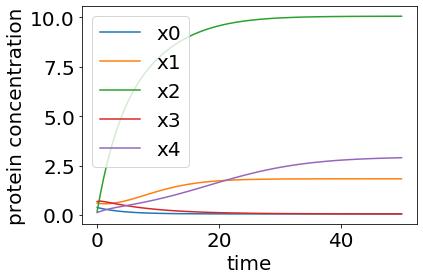

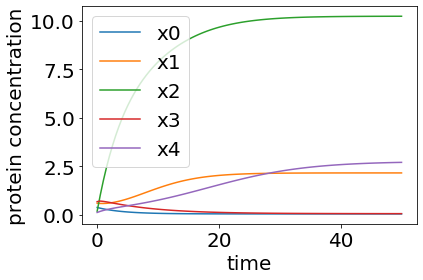

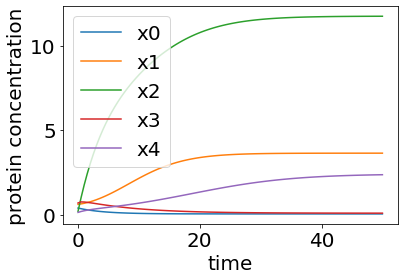

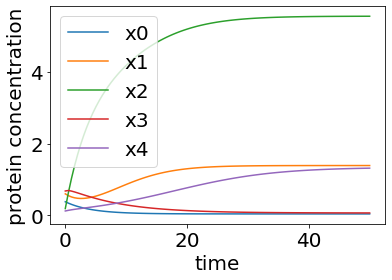

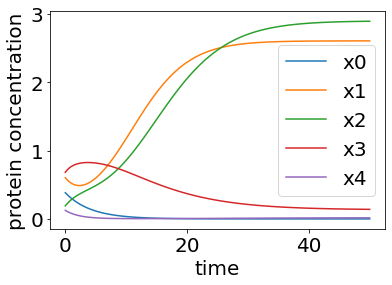

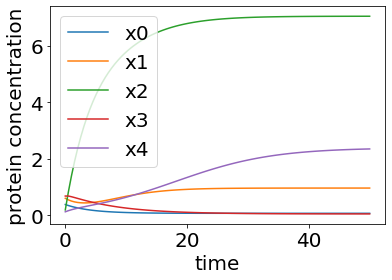

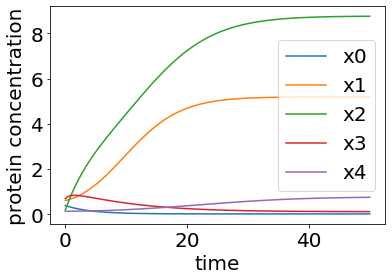

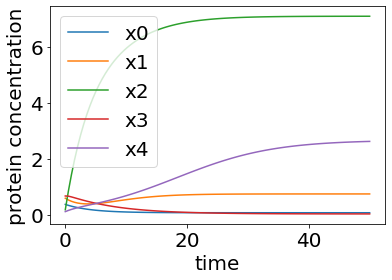

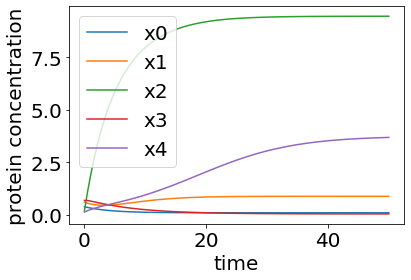

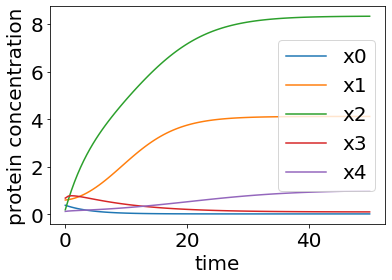

In [61]:
numStates = 5
numInputs = 2

tStart = 0.0
tEnd = 50
numTimesteps = 100
numTimepoints = np.int(numTimesteps)
tSpan = np.linspace(tStart,tEnd,numTimepoints)

numTrajectories = 20

uvec = np.empty(shape=[numInputs,numTimepoints,numTrajectories])
data = np.empty(shape=[numStates,numTimepoints,0])
for traj in range(0,numTrajectories):
#     u = np.random.uniform(0.1,1,numInputs).reshape(numInputs,1)
    if traj == 0:
        u = np.array([0,10]).reshape(numInputs,1)
    else:
        u = np.random.uniform(0,10,numInputs).reshape(numInputs,1)
#     x0 = np.random.uniform(0.1,0.8,numStates)
    x0 = np.array([0.38333705, 0.60372205, 0.19228367, 0.68349721, 0.12565985])
    x = odeint(iff_loop,x0,tSpan,args=(u,))
    x = x.T[:,:,np.newaxis]
    data = np.append(data,x,axis=2)
    uvec[:,:,traj] = u*np.ones((numInputs,numTimepoints))
    
    if numTrajectories < 21:
        plt.figure();
        h = plt.plot(tSpan,data[:,:,traj].T);
        plt.legend((h[0],h[1],h[2],h[3],h[4]),('x0','x1','x2','x3','x4'),loc='best');
        plt.xlabel('time');
        plt.ylabel('protein concentration');
# uvec = np.array(uvec)
# print(x[3,-1])

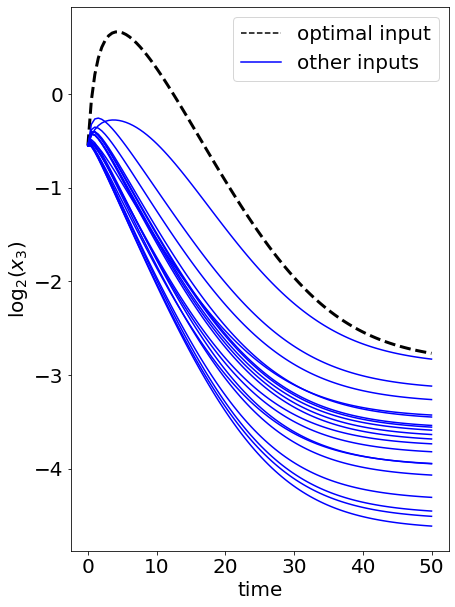

In [63]:
import matplotlib.lines as mlines

maxState = 3

plt.figure(figsize=(7,10));
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.15)
p = plt.plot(tSpan,np.log2(data[maxState,:,0]),color='black',linestyle='--',linewidth=3)
for traj in range(1,numTrajectories):
    plt.plot(tSpan,np.log2(data[maxState,:,traj]).T,color='blue')
plt.xlabel('time')
plt.ylabel(r'$\log_2(x_3)$')
# plt.title(r'$\alpha > \beta$')
optInput = mlines.Line2D([], [], color='black',linestyle='--',label='optimal input')
otherInput = mlines.Line2D([], [], color='blue',linestyle='-',label='other inputs')
plt.legend(handles=[optInput,otherInput]);

import os
filename = 'incoherent_ff_loop_optimal_input_x3.pdf'
path = '/users/aqib/desktop/ucsb/research/bccl/koopman_ss_prog/code'
fullpath = os.path.join(path, filename)
target_file = fullpath
# plt.savefig(target_file);

# save data to pickle file

In [ ]:
# pickle.dump( favorite_color, open( "save.p", "wb" ) )
# trpdata = pickle.load( open( "trp_input_ideal.pickle", "rb" ) )

In [ ]:
# # put data in rank two tensor format
# # deepDMD takes the data formatted with snapshots along the rows. ???
# indices_p = list(range(0,numTimepoints-1))
# indices_f = list(range(1,numTimepoints))

# data_x_p = data[:,indices_p].reshape((numStates,len(indices_p)*numTrajectories),order='F').T
# data_x_f = data[:,indices_f].reshape((numStates,len(indices_f)*numTrajectories),order='F').T
# data_u_p = uvec[:,indices_p].reshape((numInputs,len(indices_p)*numTrajectories),order='F').T

# dataList = [data_x_p,data_x_f,data_u_p]

# pickle.dump(dataList,open('incoherent_ff_loop.pickle','wb'))

## identify A and B using input Koopman formulation

In [ ]:
train_start = 0
train_stop = round(0.5*numTimepoints)
train_step = 1
train_indices = np.arange(train_start, train_stop+train_step, train_step)
max_train_index = train_indices[-1]

polyorder_x = 3
polyorder_u = 3

# # one-step prediction optimization
# psi_x_p = Monomials(data[:,0:max_train_index],polyorder_x)
# psi_x_f = Monomials(data[:,1:max_train_index+1],polyorder_x)
# psi_u = Monomials(uvec[:,0:max_train_index],polyorder_u)
# psi_xu = Monomials_xu(psi_x_p,psi_u)

# pure N-step prediction optimization
N = 50
train_indices_p = list(range(0,max_train_index-N))
train_data_p = data[:,train_indices_p]
train_indices_f = list(range(N,max_train_index))
train_data_f = data[:,train_indices_f]

psi_x_p_train = Monomials(train_data_p,polyorder_x)
psi_x_f_train = Monomials(train_data_f,polyorder_x)
psi_u_train = Monomials(uvec[:,train_indices_p],polyorder_u)
psi_xu_train = Monomials_xu(psi_x_p_train,psi_u_train)


numObs_x = psi_x_p_train.shape[0]
numObs_u = psi_u_train.shape[0]
numObs_xu = psi_xu_train.shape[0]

In [ ]:
print(psi_x_p_train.shape)
print(psi_xu_train.shape)
print(psi_u_train.shape)

In [ ]:
K,A,B = calc_Input_Koopman(psi_x_p_train,psi_x_f_train,psi_u_train,psi_xu_train,trunc_cond=1e-8)

In [ ]:
plt.figure();
sn.heatmap(A);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim(); # get the top and bottom location 
b += 0.5; # Add 0.5 to the bottom
t -= 0.5; # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

plt.figure();
sn.heatmap(B);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim(); # get the top and bottom location 
b += 0.5; # Add 0.5 to the bottom
t -= 0.5; # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

In [ ]:
eigvals = np.linalg.eigvals(A)
plt.figure();
plt.plot(eigvals.real,eigvals.imag,'o');
plt.xlabel('Re(eigvals_A)');
plt.ylabel('Im(eigvals_A)');

# predict on training data 

In [ ]:
traj = 0

psi_x_f_pred = np.dot(K,np.squeeze((np.vstack((psi_x_p_train[:,:,traj],psi_xu_train[:,:,traj],psi_u_train[:,:,traj])))))


if numObs_x > 20:
    numObs_x_plot = 20
else:
    numObs_x_plot = numObs_x
for i in range(0,numObs_x_plot):
    obsInd_temp = np.int(i)
    plt.figure()
    plt.plot(psi_x_f_train[obsInd_temp,:,traj],'.');
#     plt.plot(psi_x_p_train[obsInd_temp,:,traj],'.');
    plt.plot(psi_x_f_pred[obsInd_temp,:],'.');
    plt.gca().legend(('True','Predicted'));
    plt.title('Observable function index = ' + str(obsInd_temp))
    plt.xlabel('Time')
    plt.ylabel('Psi')
    plt.grid(False)

# Does the model work for a new initial condition, new input? 

In [ ]:
numTrajectories = 1

uvec = np.empty(shape=[numInputs,numTimepoints,numTrajectories])
data = np.empty(shape=[numStates,numTimepoints,0])
for traj in range(0,numTrajectories):
    u = np.random.uniform(0.1,0.9,numInputs).reshape(numInputs,1)
    x0 = np.random.uniform(0.01,0.8,numStates)
    x = odeint(iff_loop,x0,tSpan,args=(u,))
    x = x.T[:,:,np.newaxis]
    data = np.append(data,x,axis=2)
    uvec[:,:,traj] = u*np.ones((numInputs,numTimepoints))
    
    if numTrajectories < 21:
        plt.figure();
        h = plt.plot(tSpan,data[:,:,traj].T);
        plt.legend((h[0],h[1],h[2],h[3],h[4]),('x0','x1','x2','x3','x4'),loc='best');
        plt.xlabel('time');
        plt.ylabel('protein concentration');

In [ ]:
test_indices_p = list(range(0,data.shape[1]-N))
test_data_p = data[:,test_indices_p]
test_indices_f = list(range(N,data.shape[1]))
test_data_f = data[:,test_indices_f]

psi_x_p_test = Monomials(test_data_p,polyorder_x)
psi_x_f_test = Monomials(test_data_f,polyorder_x)
psi_u_test = Monomials(uvec[:,test_indices_p],polyorder_u)
psi_xu_test = Monomials_xu(psi_x_p_test,psi_u_test)

In [ ]:
print(psi_x_p_test.shape)
print(psi_xu_test.shape)
print(psi_u_test.shape)

In [ ]:
psi_x_f_pred = np.dot(K,np.squeeze((np.vstack((psi_x_p_test,psi_xu_test,psi_u_test)))))

if numObs_x > 20:
    numObs_x_plot = 20
else:
    numObs_x_plot = numObs_x
    
for i in range(0,numObs_x_plot):
    obsInd_temp = np.int(i)
    plt.figure()
#     plt.plot(psi_x_f_test[obsInd_temp,:],'.');
#     plt.plot(psi_x_f_pred[obsInd_temp,:]);
    plt.plot(psi_x_f_test[obsInd_temp,:],'.');
    plt.plot(psi_x_f_pred[obsInd_temp,:],'.');
    plt.gca().legend(('True','Predicted'));
    plt.title('Observable function index = ' + str(obsInd_temp))
    plt.xlabel('Time')
    plt.ylabel('Psi')
    plt.grid(False)
#     plt.xlim([300,400])
    

# N-step prediction

In [ ]:
psi_x_p = np.squeeze(psi_x_p)
psi_x_f = np.squeeze(psi_x_f)
psi_u = np.squeeze(psi_u)
psi_xu = np.squeeze(psi_xu)

T = 20
predSpan = np.linspace(0,T-1,T)
obsInd = 6

psi_x_f_pred_init = psi_x_p[:,0].reshape(len(psi_x_p[:,0]),1)
psi_xu_pred = psi_xu[:,0].reshape(len(psi_xu[:,0]),1)
psi_x_f_pred = np.empty(shape=[numObs_x,T])
plt.figure();
for i in range(0,T):
    psi_x_f_pred_temp = np.dot(np.linalg.matrix_power(A,i+1),psi_x_f_pred_init) + \
                            np.dot(B,(np.vstack((psi_xu_pred, psi_u[:,i].reshape(len(psi_u[:,i]),1))))) 
    psi_x_f_pred[:,i] = np.squeeze(psi_x_f_pred_temp)
    psi_xu_pred = np.squeeze(Monomials_xu(psi_x_f_pred[:,i].reshape(len(psi_x_f_pred[:,0]),1),psi_u[:,i+1].reshape(len(psi_u[:,0]),1)),2)
    plt.plot(predSpan[i],psi_x_p[obsInd,i],'o',color='green')
    plt.plot(predSpan[i],psi_x_f_pred[obsInd,i],'o',color='red')
plt.gca().legend(('True','Predicted'));